In [42]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import quandl
import yfinance as yf
import scipy.optimize as sco

plt.style.use('fivethirtyeight')
np.random.seed(777)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [52]:
#select the stocks for the portfolio
stocks = ['FSTA','FMAT','FCOM','FDIS', 'ISTB', 'FNCL', 'FHLC', 'FIDU', 'SCHH', 'FTEC', 'FUTY'] #doesn't work with nasdaq data link, other sources?
#stocks = ['AAPL','AMZN','GOOGL','FB']
start_date="2012-10-01"
end_date="2022-10-01"

#Download the data from quandl 
quandl.ApiConfig.api_key = 'xTVy37nULase-U5T7yxf'

data = quandl.get_table('WIKI/PRICES', ticker = stocks,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                        date = { 'gte': start_date, 'lte': end_date }, paginate=True)

#Change index to date
df = data.set_index('date')

#Put tickers in column headers
table = df.pivot(columns='ticker')
# By specifying col[1] in below list comprehension
# You can select the stock names under multi-level column
table.columns = [col[1] for col in table.columns]
table.head()


#In case quandl data is not available, we can download from yfinance
if len(data)== 0:
    data = yf.download(stocks, start=start_date, end=end_date)
    data = data['Adj Close']
    table = data

#Check data
data.tail()


[*********************100%***********************]  11 of 11 completed


,FCOM,FDIS,FHLC,FIDU,FMAT,FNCL,FSTA,FTEC,FUTY,ISTB,SCHH
Date,,,,,,,,,,,
2022-09-26,31.570000,62.029999,57.619999,44.040001,37.650002,43.439999,41.619999,93.589996,45.099998,45.819263,18.879999
2022-09-27,31.450001,62.270000,57.549999,43.889999,37.730000,43.200001,40.950001,93.879997,44.279999,45.749538,18.629999
2022-09-28,32.470001,64.120003,58.910000,44.970001,38.700001,44.080002,41.480000,95.010002,44.799999,46.118084,19.000000
2022-09-29,31.629999,61.910000,58.389999,44.119999,38.099998,43.450001,40.759998,92.580002,43.049999,45.998558,18.450001
2022-09-30,31.280001,60.860001,57.650002,43.680000,38.009998,43.080002,40.150002,90.930000,42.220001,45.918869,18.690001


Text(0, 0.5, 'price in $')

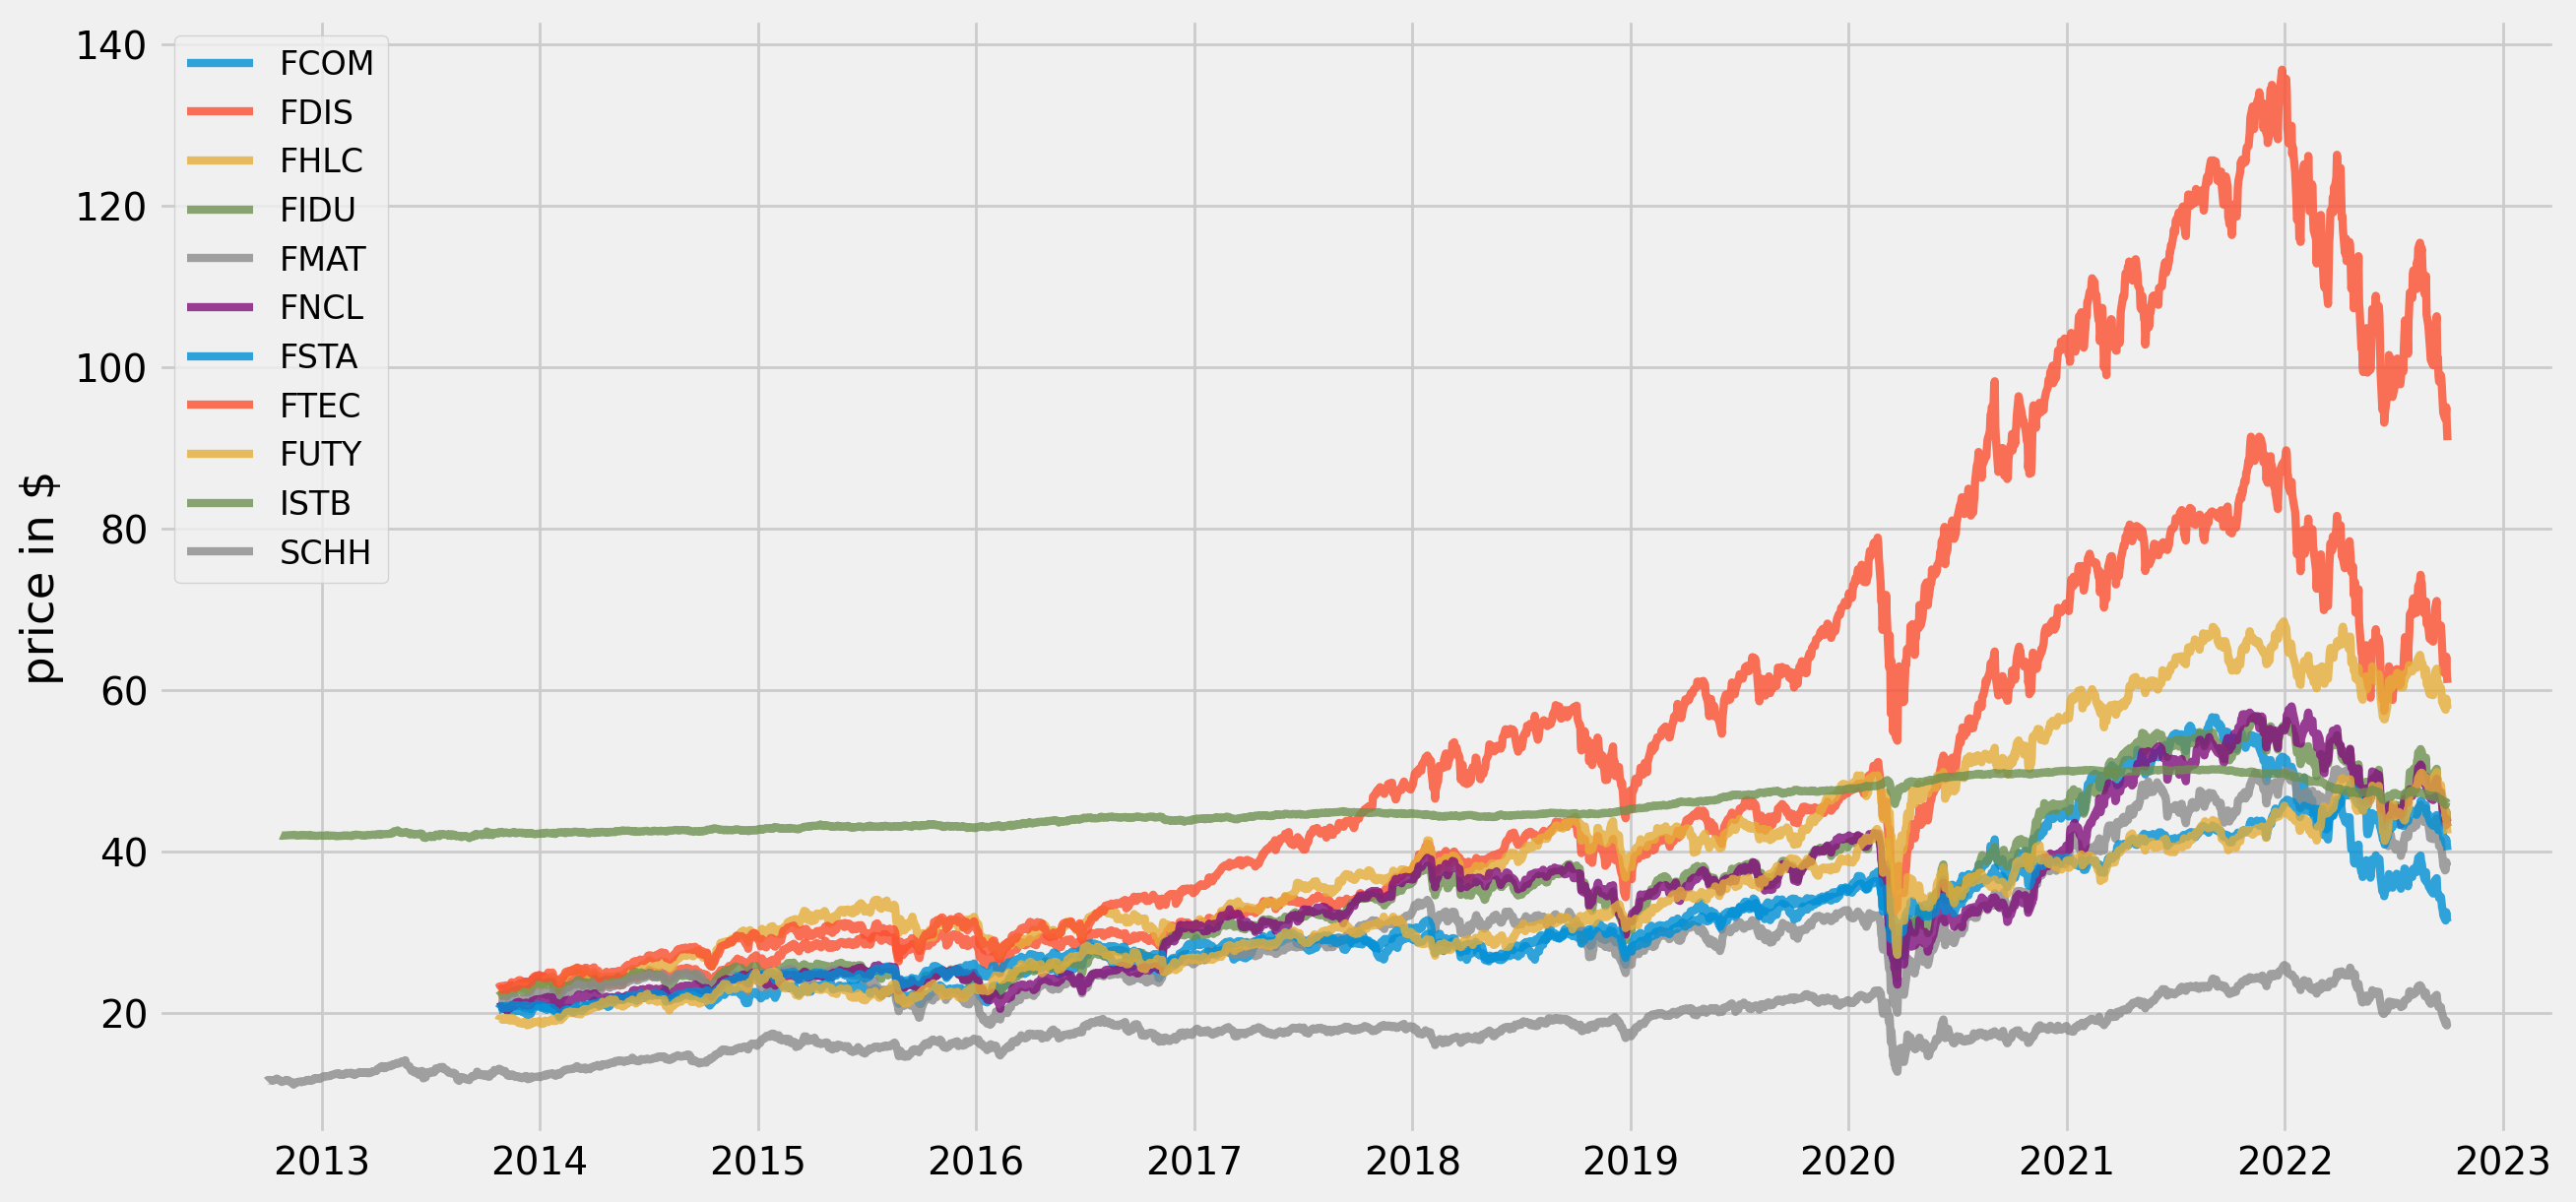

In [53]:
#Plot the historical prices of the stocks selected
plt.figure(figsize=(14, 7))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

Text(0, 0.5, 'daily returns')

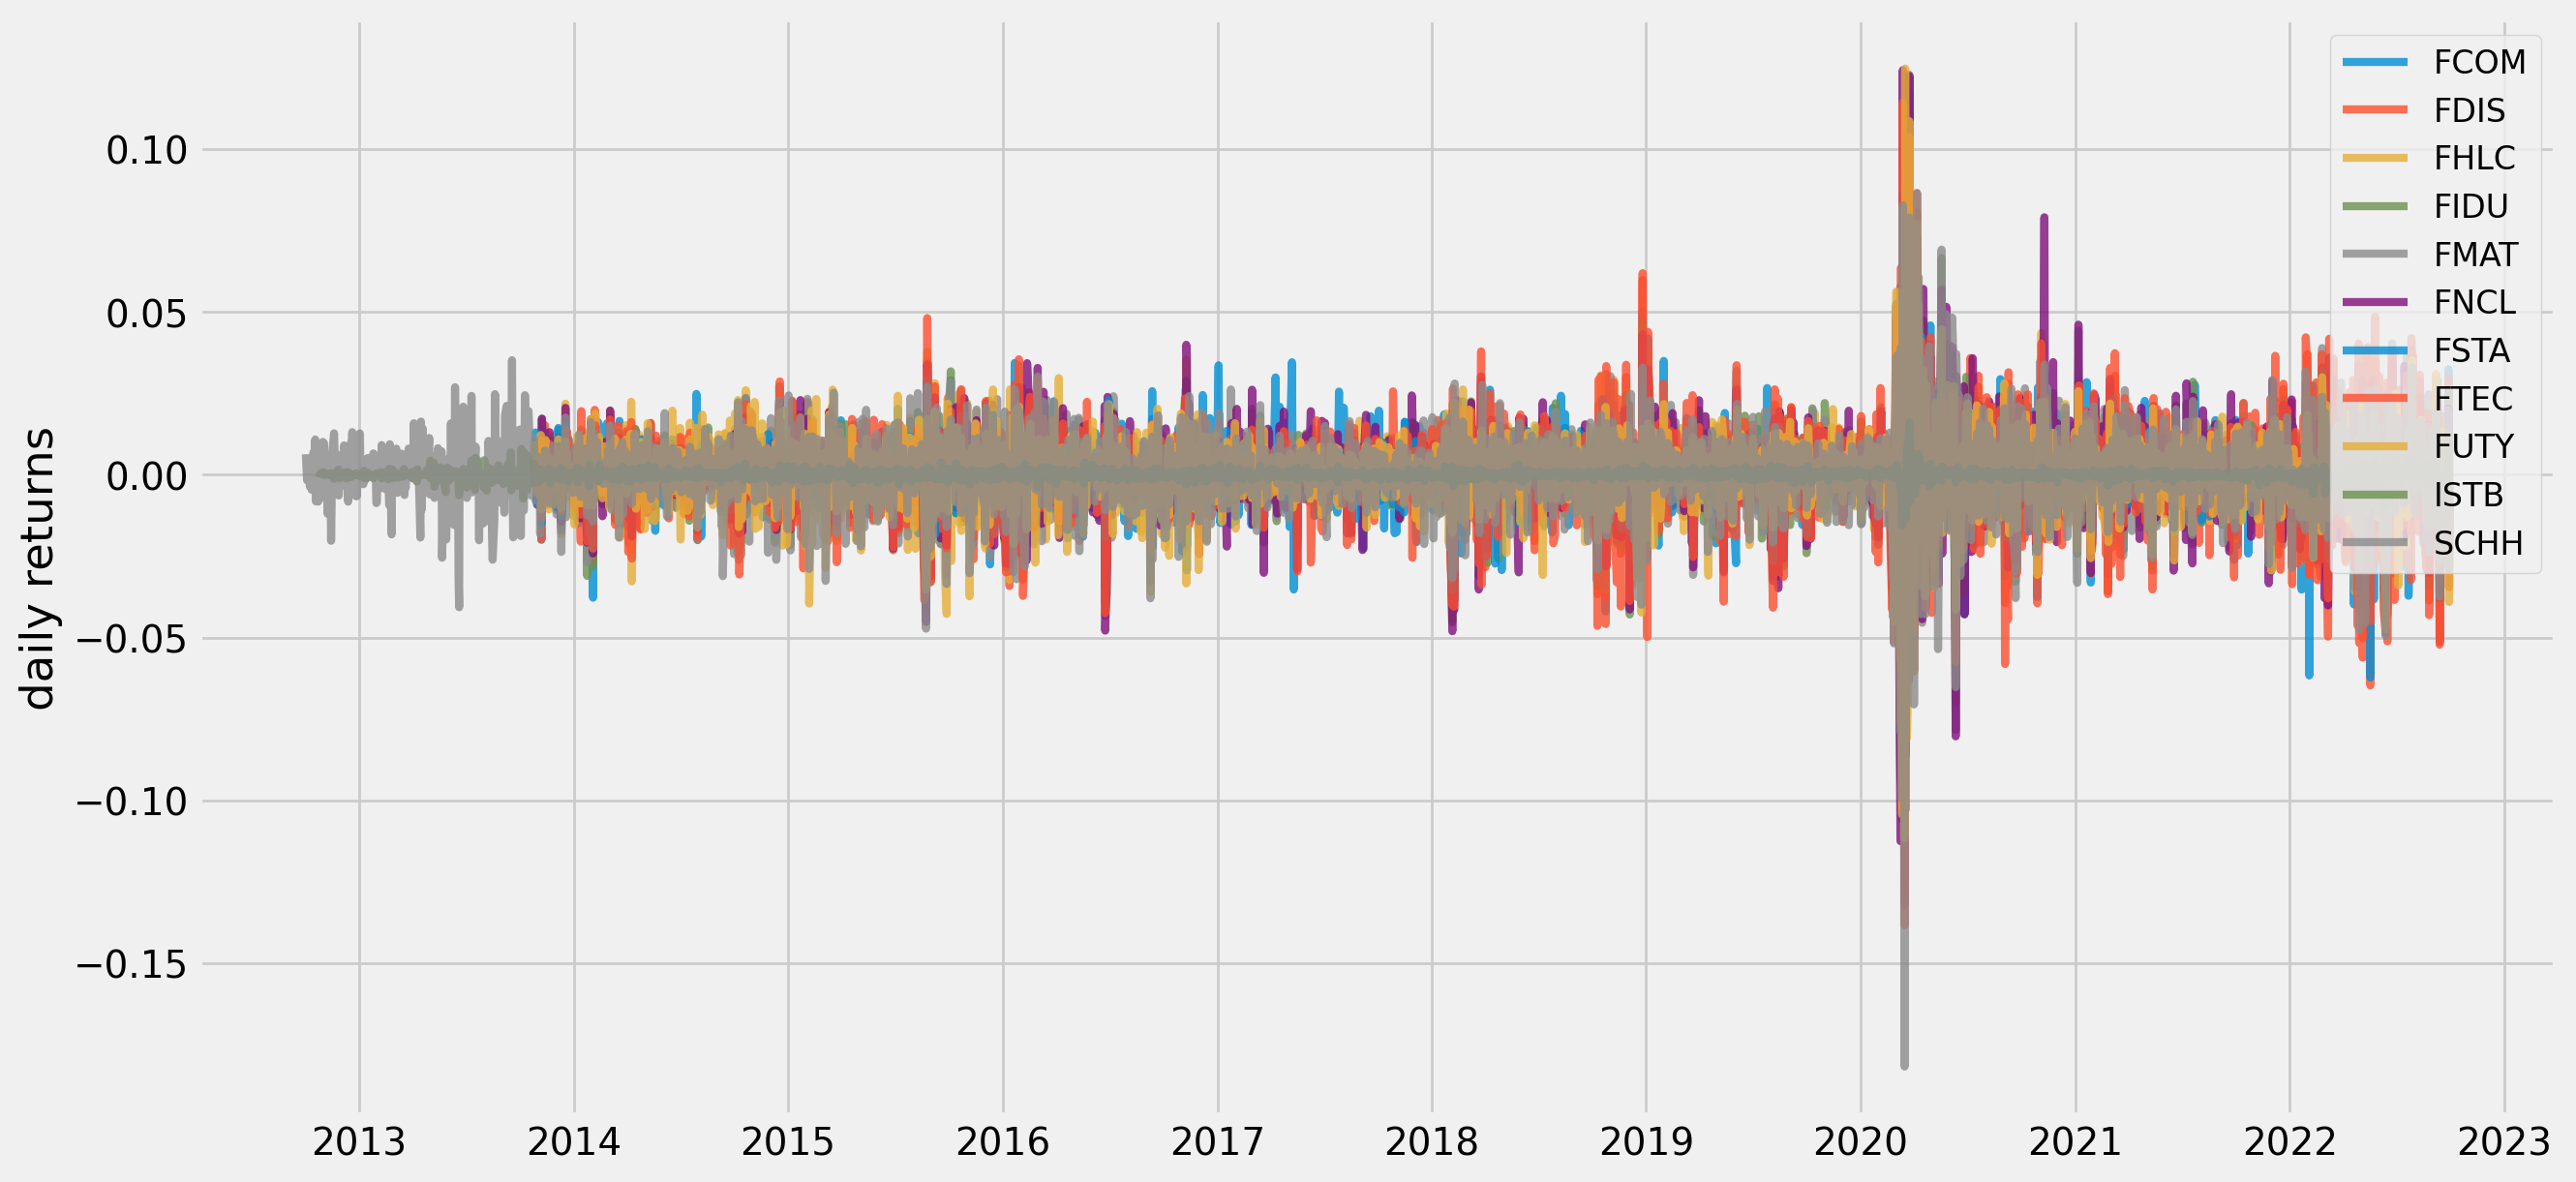

In [54]:
#Plot the daily returns of the stocks
returns = table.pct_change()

plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

In [59]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

In [78]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(stocks))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [81]:
returns = table.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 125000
risk_free_rate = 0.0382

In [79]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    print("-"*80)
    print("\n")
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.13
Annualised Volatility: 0.18


            FCOM  FDIS  FHLC  FIDU  FMAT  FNCL  FSTA   FTEC  FUTY  ISTB  SCHH
allocation  4.26  4.48  25.7  8.47  6.07   0.6  8.56  34.96  4.89  0.31   1.7
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.07
Annualised Volatility: 0.11


            FCOM  FDIS  FHLC  FIDU  FMAT   FNCL   FSTA  FTEC   FUTY   ISTB  \
allocation  5.45   1.2  1.84   3.7  3.62  11.96  13.82  5.39  13.34  35.05   

            SCHH  
allocation  4.64  
--------------------------------------------------------------------------------




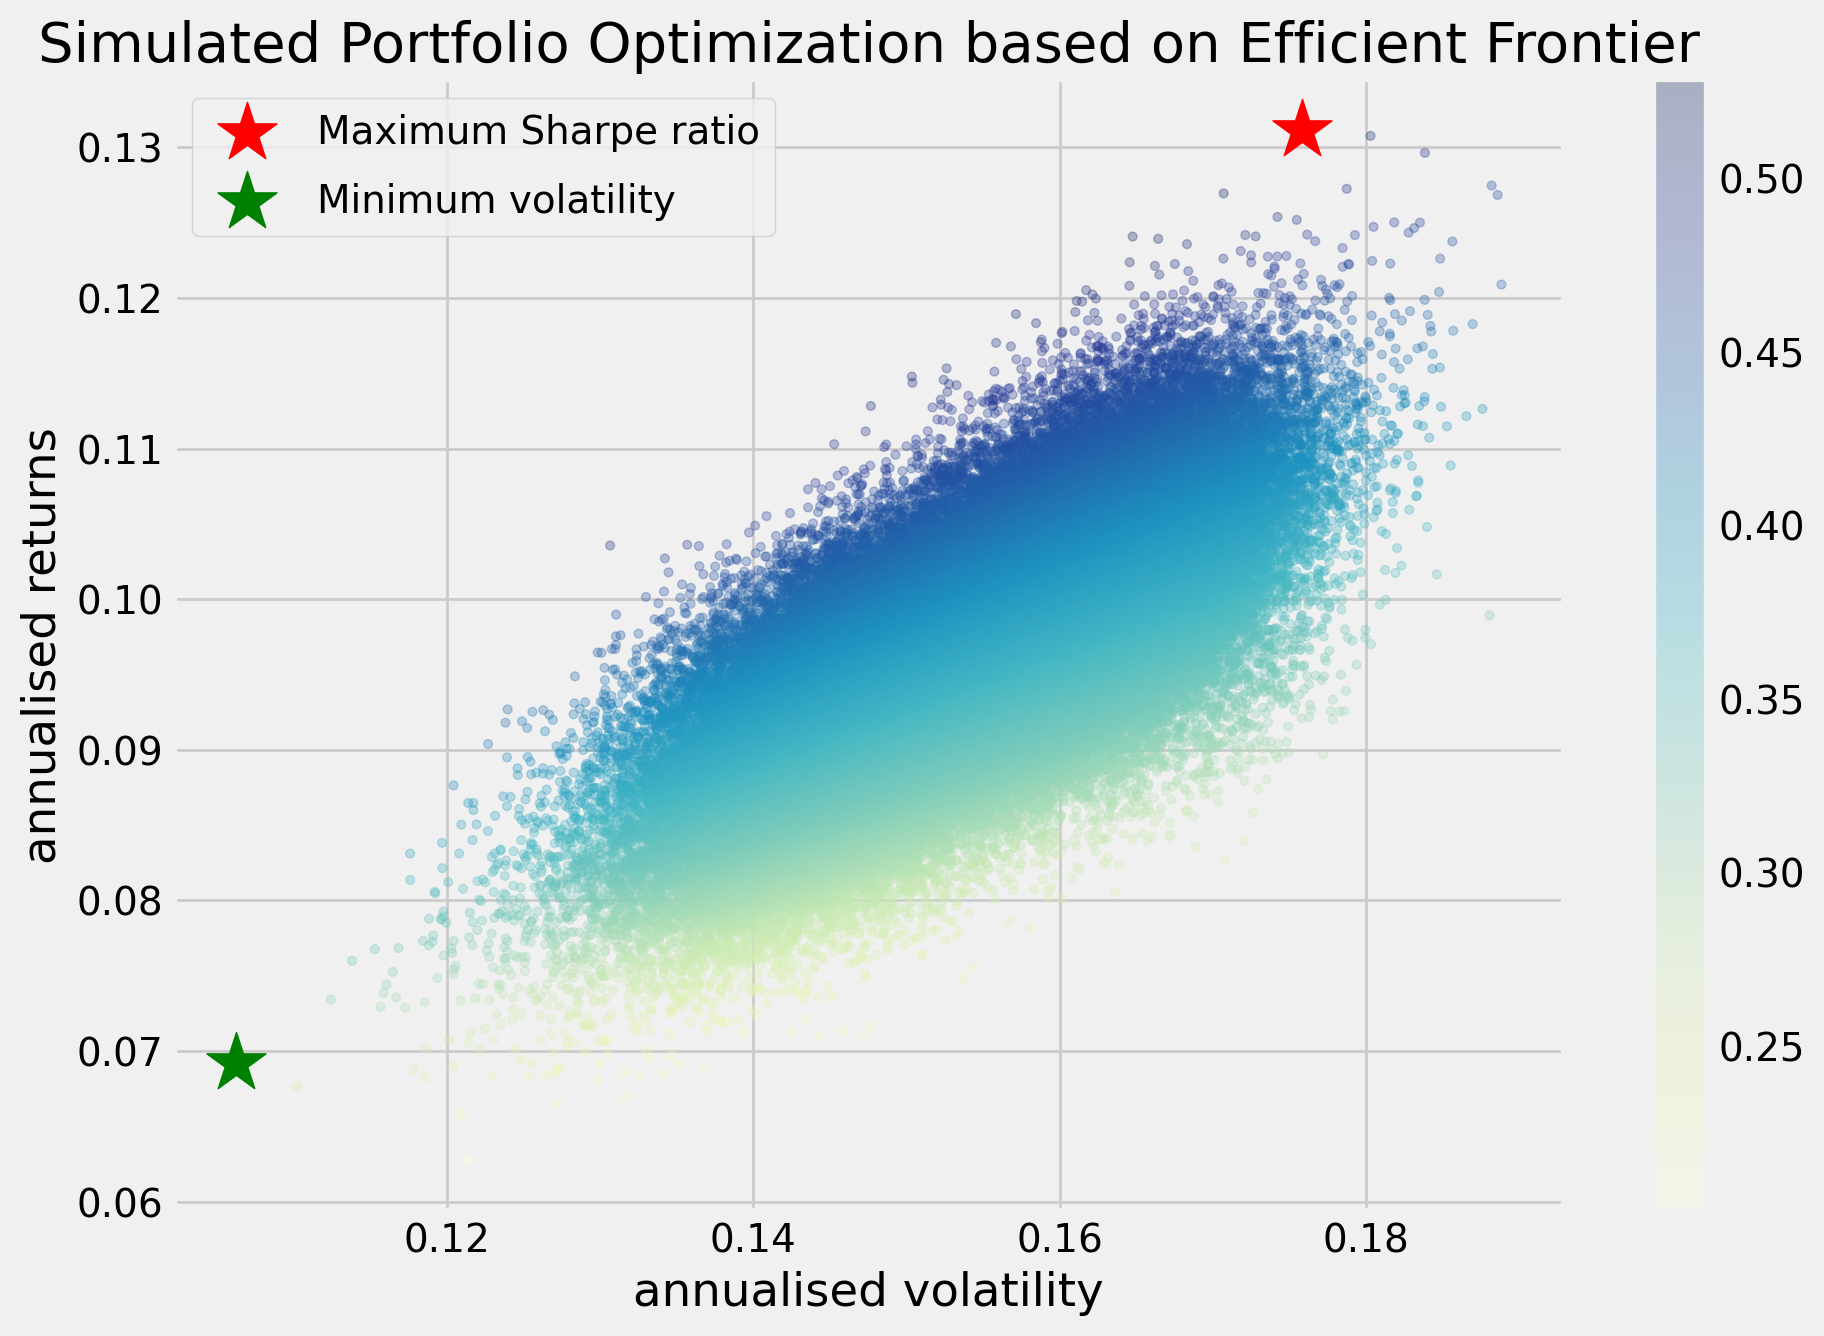

In [82]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)